# 2-4-1. 상호정보량

#### 동시발생 행렬의 원소: 두 단어가 동시에 발생한 횟수를 나타냄.
 - 단어 빈도만으로는 그리 의미있는 특징을 찾을 수 없음(ex. "the", "car").
 - 가장 중요한 것은 단어 간의 관련성이다. 
 - "car"는 "drive"와 관련이 깊다. 그러나 이때 빈도만을 고려한다면, "the"와 더 관련성이 강하다고 나올 것이다.

#### 문제 해결의 열쇠: 점별 상호정보량(Pointwise Mutual Information, PMI)
 - PMI(x, y) = log2(  P(x, y) / P(x)P(y)  )
 -           = log2(  n * C(x, y) / C(x)C(y)  ) 

   * P(x, y) : x와 y가 동시발생할 확률, P(x) & P(y): 단어 x 또는 y가 출현할 확률.
   * C(x, y) : x와 y가 동시발생하는 횟수, C(x) & C(y): 단어 x 또는 y가 출현하는 횟수,
   * n : 말뭉치 내 단어 개수.
    
 - PMI의 장점: 단어가 단독으로 출현하는 횟수를 고려함으로써 동시발생 횟수만 고려할 시의 문제 해결.
 - PMI의 단점: x와 y가 동시발생하는 횟수가 0이면 PMI(x, y)가 음의 무한대가 되어버린다. 

#### PMI의 보완: 양의 상호정보량(Positive PMI: PPMI)
 - PPMI(x, y) = max(0, PMI(x, y))

 - 단어 사이의 관련성을 0 이상의 실수로 나타냄.
 - PMI가 음수일 때는 0으로 취급.

In [3]:
#동시발생 행렬을 PPMI행렬로 변환하는 함수 구현

#전처리 함수 로딩
import numpy as np

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
        
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [4]:
#PPMI행렬로 변환하는 함수 구현
#C : 동시발생행렬
#verbose: 진행상황 출력 여부를 결정하는 플래그. 큰 말뭉치를 다룰 때 True로 설정.
#eps: pmi가 0이 되는 걸 막기 위해 추가하는 작은 값.
def ppmi(C, verbose = False, eps = 1e-8):
    M = np.zeros_like(C, dtype = np.float32)
    N = np.sum(C)
    S = np.sum(C, axis = 0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2( C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total // 100) == 0:
                    print('%.1f%%' %(100 * cnt / total))

    return M

In [6]:
#ppmi 함수 활용 예제.
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision = 3)  #유효 자릿수를 세 자리로 표시
print("동시발생 행렬")
print(C)
print("-" * 50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


#### PPMI의 보완: 양의 상호정보량(Positive PMI: PPMI)
 - 어휘 수만큼 차원이 늘어남(10만개짜리 코퍼스는 10만 차원)
 - 원소가 0에 가까울수록 중요도가 떨어지는 원소임. 그래서 PPMI는 노이즈에 취약함.
 - 적절한 수의 차원을 갖도록 차원 감소가 필요하다.

# 2-4-2. 차원 감소

#### 차원 감소(dimensionality reduction)
 - 중요한 정보는 최대한 유지하면서 벡터의 차원을 줄이는 것.

 - 대표적인 차원감소 방법: 특잇값분해(SVD, Singular Value Decomposition)

# 2-4-3. SVD에 의한 차원 감소

In [7]:
#동시발생 행렬을 만들어 PPMI 행렬로 변환한 다음 SVD 적용
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size, window_size = 1)
W = ppmi(C)

#SVD
U, S, V = np.linalg.svd(W)   #변환된 밀집벡터는 U에 저장됨.
print(C[0])  #동시발생 행렬
print(W[0])  #PPMI 행렬
print(U[0])  #SVD

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 0.000e+00  3.409e-01 -1.205e-01 -3.886e-16 -1.110e-16 -9.323e-01
 -2.426e-17]


In [8]:
#밀집벡터의 차원을 2차원으로 감소시키기
print(U[0, :2])

[0.    0.341]


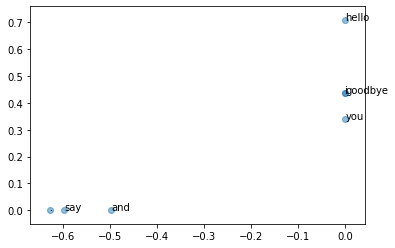

In [10]:
#각 단어를 2차원 벡터로 표현 후 그래프로 그려보자.

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))  #plt.annotate(x, y): 좌표 x, y지점에 word에 담긴 텍스트를 그림.
    
plt.scatter(U[:, 0], U[:, 1], alpha = 0.5)
plt.show()

# 2-4-4. PTB 데이터셋

In [11]:
#PTB 말뭉치를 활용한 SVD 실습
#PTB 말뭉치 불러오기 및 데이터셋 설명

import sys
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train') #ptb.load_data('train'): 데이터 읽어들이기.
                                                        #인수 지정 가능(train, test, valid 중)
print('말뭉치 크기:', len(corpus))
print('corpus[:30]: ', corpus[:30])     #corpus: 단어 ID 목록 저장
print()
print('id_to_word[0]: ', id_to_word[0]) #id_to_word: ID를 단어로 변환하는 딕셔너리
print('id_to_word[1]: ', id_to_word[1])
print('id_to_word[2]: ', id_to_word[2])
print()
print("word_to_id['car']: ", word_to_id['car']) #word_to_id: 단어를 ID로 변환하는 딕셔너리
print("word_to_id['happy']: ", word_to_id['happy'])
print("word_to_id['lexus']: ", word_to_id['lexus'])

Done
말뭉치 크기: 929589
corpus[:30]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]:  aer
id_to_word[1]:  banknote
id_to_word[2]:  berlitz

word_to_id['car']:  3856
word_to_id['happy']:  4428
word_to_id['lexus']:  7426


# 2-4-5. PTB 데이터셋 평가

In [12]:
#큰 행렬에 SVD 적용.
#시간 및 메모리 경량화를 위해 scikit learn 모듈 사용
import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산...')
W = ppmi(C, verbose = True)

print('SVD 계산...')
try:
    #truncated SVD(더 빠름)            #↓ 무작위 수를 사용한 Truncated SVD ==> 실행 결과가 매번 다름.
    from sklearn.utils.extmath import randomized_svd  #특잇값이 큰 것들만 계산하여 기본 SVD보다 속도가 빠름.
    U, S, V = randomized_svd(W, n_components = wordvec_size, n_iter = 5, random_state = None)
    
except ImportError:
    #SVD(느림)
    U, S, V = np.linalg.svd(W)
    
word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top = 5)
    

동시발생 수 계산...
PPMI 계산...


..\common\util.py:141: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
..\common\util.py:141: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료
SVD 계산...

[query] you
 i: 0.7404420971870422
 we: 0.655971884727478
 do: 0.5453001856803894
 anybody: 0.543

# 정리
 - '단어의 의미'를 컴퓨터에게 이해시키는 과정.
  * 1. 시소러스 기법: 사람이 수작업으로 단어들의 관련성을 정의.
  * 2. 통계 기반 기법: 말뭉치 안의 각 단어의 주변 단어들의 빈도를 집계(동시발생 행렬), 단어의 의미를 자동으로 추출한 후 벡터로 표현

 - 통계 기반 기법: 의미, 문법적 용법이 비슷한 단어들이 벡터 공간에서도 서로 가까이 모여있음을 보여줌.
  * 단어의 동시발생 행렬을 생성.
  * 동시발생 행렬을 PPMI로 변환.
  * SVD를 이용해 차원 감소.

 - 전처리 함수 구현
  * 벡터 간 유사도 측정: cos_similarity()
  * 유사 단어 랭킹 표시: most_similar()